In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
from torch.utils.data import Subset
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Subset, DataLoader


In [ ]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [ ]:
#task to colorize image
# will give model uncolered images so transform images
# compare reconstructed image with original



transform = transforms.Compose([
    #transforms.RandomResizedCrop(64),  # Randomly crops the image and then resizes it to 64x64
    #transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
    #transforms.RandomRotation(20),  # Randomly rotates the image within a 20-degree range
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly jitters the color properties
    #transforms.ToTensor(),  # Converts the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the image
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
(gs_img, rgb_img), _ = image_dataset[0]  # _ is the image class which we don't need for this assignment

In [ ]:
gs_img.shape

torch.Size([1, 128, 128])

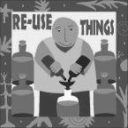

In [ ]:
transforms.functional.to_pil_image(gs_img)

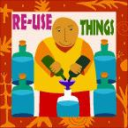

In [ ]:
transforms.functional.to_pil_image(rgb_img)

In [ ]:
print(len(image_dataset))

9144


# Tasks:

1. Build a custo [AutoEncoder] NN model. The input to the model is the Gray Scale Image and it's output should be colored image.
2. Split the data into training and validation splits (80%, 20%). Train the model on training data.
3. After training, show final loss value as well as draw a plot to show how loss dropped during training (both train and val loss).
4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.

In [ ]:
#Task1:
class CustomSegModel(nn.Module):  # Unet architecture based
    def __init__(self, in_channels, out_channels):
        super(CustomSegModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # size64 x 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #32 x 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #16 x 16

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) #8 x 8
        )

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # upsample to 16
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), #32

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), # 64

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), #128

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1) # kernel 1 acts as Linear layer
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

In [ ]:
import torch.nn as nn

# Define Autoencoder Model
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(CNNAutoEncoder, self).__init__()

        # Encoder (Feature Extraction) (reducing image into a latent space)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # (28x28) → (14x14) ((in_channels, out_channels, kernel_size, stride, padding=1))
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # (14x14) → (7x7)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Flatten(),  # Flatten to vector
            nn.Linear(32 * 7 * 7, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(), # Why Tanh? we want values between a fix scale -1 to 1 works better
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 7 * 7),
            nn.BatchNorm1d(32 * 7 * 7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 7, 7)),  # Reshape back , (batch_size,(32* 7* 7)) to (batch size, 32, 7, 7)
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (7x7) → (14x14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3,2, 1, output_padding=1),  # (14x14) → (28x28)
            nn.Sigmoid(),  # why sigmoid: using tensor and tensor scales images between zero and one since we want to reconstruc the same image
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out

In [ ]:
#used

import torch
import torch.nn as nn

class ColorizationAutoencoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduces to 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduces to 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduces to 16 x 16
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.Sigmoid()  # Using sigmoid to scale the output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
#Task splitting
val_len= int(0.2*len(image_dataset))
train_len= len(image_dataset)-val_len
train_dataset,val_dataset=random_split(image_dataset,[train_len,val_len],generator=torch.Generator().manual_seed(1))

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False) #no need for shuffling val set

In [ ]:
batch=next(iter(val_loader))

In [ ]:
(batch_X, batch_y),_=batch
np.shape(batch_X),np.shape(batch_y)

(torch.Size([64, 1, 128, 128]), torch.Size([64, 3, 128, 128]))

In [ ]:
# Task3:
in_channels = 1  # bc grayscale
out_channels = 3  # for RGB images (3 channels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ColorizationAutoencoder(in_channels, out_channels).to(device)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNNAutoEncoder(encoding_dim=8).to(device)


In [ ]:
# Task3:
in_channels = 1  # bc grayscale
out_channels = 3  # for RGB images (3 channels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomSegModel(in_channels, out_channels).to(device)

In [ ]:
num_epochs = 7
lr = 1e-2

train_losses = []
val_losses = []

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean') #regression problem

print(f'Using device {device}')

Using device cuda


In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for (batch_X, batch_y),_ in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    batch_y = batch_y.squeeze(dim=1)

    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())


  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for (val_batch_X, val_batch_y),_ in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)
      val_batch_y = val_batch_y.squeeze(dim=1)

      val_batch_y_probs = model(val_batch_X) # send in gs image

      loss = criterion(val_batch_y_probs, val_batch_y) # compare contruction with rgb image

      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob


  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}.')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=0.04310254770967072, val_loss=0.019727391551536074.
Epoch: 1, train_loss=0.01648020967912436, val_loss=0.014679686661556982.
Epoch: 2, train_loss=0.014507934323803788, val_loss=0.014210167188091403.
Epoch: 3, train_loss=0.0134658198197718, val_loss=0.013324305062595942.
Epoch: 4, train_loss=0.013054333281987934, val_loss=0.013547428043995306.
Epoch: 5, train_loss=0.012736530654731182, val_loss=0.013137251242620288.
Epoch: 6, train_loss=0.012348657033974971, val_loss=0.012013669714690298.
Training complete on device cuda.
CPU times: user 4min 42s, sys: 3.33 s, total: 4min 45s
Wall time: 4min 49s


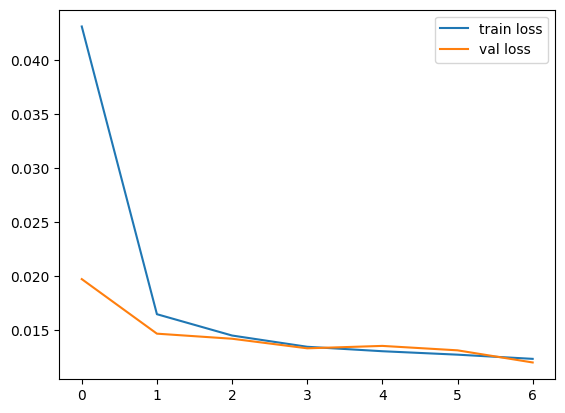

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')

plt.legend()
plt.show()

In [ ]:
#Task 4:
last_grayImages,last_RGBImages=val_batch_X, val_batch_y
last_predictions=val_batch_y_probs #val_batch_y_probs because last_RGBImages is between 0 and 1 (decimal)

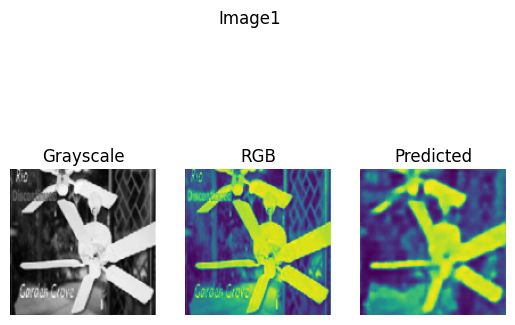

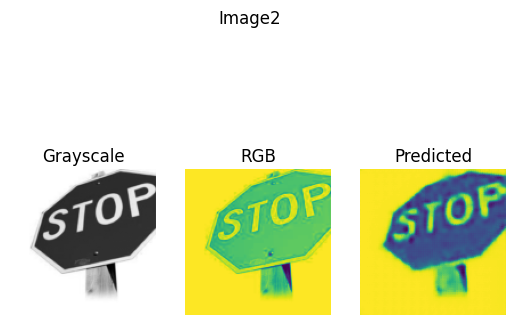

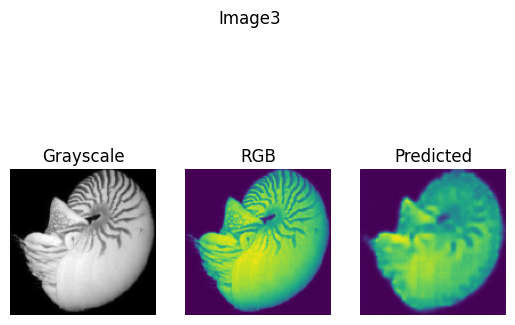

<Figure size 640x480 with 0 Axes>

In [ ]:
with torch.no_grad():
  plt.subplot(1,3,1)
  plt.imshow(last_grayImages[1][0].cpu(),cmap="gray")
  plt.title("Grayscale")
  plt.axis("off")
  plt.subplot(1,3,2)
  plt.imshow(last_RGBImages[1][0].cpu())
  plt.title("RGB")
  plt.axis("off")
  plt.subplot(1,3,3)
  plt.imshow(last_predictions[1][0].cpu())
  plt.title("Predicted")
  plt.axis("off")
  plt.suptitle("Image1")
  plt.show()

  plt.subplot(1,3,1)
  plt.imshow(last_grayImages[2][0].cpu(),cmap="gray")
  plt.title("Grayscale")
  plt.axis("off")
  plt.subplot(1,3,2)
  plt.imshow(last_RGBImages[2][0].cpu())
  plt.title("RGB")
  plt.axis("off")
  plt.subplot(1,3,3)
  plt.imshow(last_predictions[2][0].cpu())
  plt.title("Predicted")
  plt.axis("off")
  plt.suptitle("Image2")
  plt.show()

  plt.subplot(1,3,1)
  plt.imshow(last_grayImages[3][0].cpu(),cmap="gray")
  plt.title("Grayscale")
  plt.axis("off")
  plt.subplot(1,3,2)
  plt.imshow(last_RGBImages[3][0].cpu())
  plt.title("RGB")
  plt.axis("off")
  plt.subplot(1,3,3)
  plt.imshow(last_predictions[3][0].cpu())
  plt.title("Predicted")
  plt.axis("off")
  plt.suptitle("Image3")
  plt.show()


plt.tight_layout();
